In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 2SAT.cnf.csv to 2SAT.cnf (2).csv


In [60]:
#function performs unit propogation, which identifies clauses with exactly one literal, assigns value to make clause true, and cleans up rest of clauses based on this assignment
def unit_prop(clauses: list, assigned: list) -> (list, list):
    unit_found = True

    while unit_found:
        unit_found = False

        # keep track of changes while iterating
        new_clauses = []

        for clause in clauses:
            if len(clause) == 1:  # unit clause found
                unit_found = True
                literal = clause[0]
                assigned.append(literal) # add varible to list of assigned variables

                clauses = [c for c in clauses if literal not in c] # remove clauses containing this literal

                clauses = [[l for l in c if l != -literal] if any(l != -literal for l in c) else [] for c in clauses] # remove the negations of this literal from remaining clauses

                # exit early if an empty clause is found (indicating contradiction)
                if [] in clauses:
                    return clauses, assigned  # unsatisfiable due to contradiction

            else:
                new_clauses.append(clause) #if not a unit clause, keep

        clauses = new_clauses #reset clauses

    return clauses, assigned


In [61]:
# assigns and handles variables that only appear in one form as a literal (i.e. only negation), cleans up rest of clauses from there
def pure_literal(clauses : list, assigned : list) -> (list, list):
  pos_lits = set() # for unique membership
  neg_lits = set()

  for clause in clauses: # go through each clause
    for lit in clause: # and each literal in each clause
      if lit > 0:
        pos_lits.add(lit)
      else:
        neg_lits.add(lit) #if only appears as negation
  pure_lits = [lit for lit in pos_lits if -lit not in neg_lits] + [lit for lit in neg_lits if -lit not in pos_lits] #finds those unique to one set aka pure literals

  for lit in pure_lits: # go through each pure literal and handle cleaning up rest of clauses
    if lit not in assigned and -lit not in assigned:
        assigned.append(lit)  # assign as true for positive, false for negative

        # remove all clauses containing literal
        clauses = [clause for clause in clauses if lit not in clause]

        # remove the negation of the pure literal from remaining clauses (but don't remove actual clause)
        negation = -lit
        #clauses = [[l for l in clause if l != negation] for clause in clauses]
        clauses = [[l for l in c if l != negation] if any(l != negation for l in c) else [] for c in clauses]


  return clauses, assigned


In [62]:
# performs splitting, which takes first appearing variable, assigns it some truth value and performs a sort of DFS with backtracking
# (with true/false as branches) until satisfiability is determined
def splitting(clauses: list, assigned: list) -> bool:
    if not clauses:  # empty set of clauses, means all of the clauses = true for this case, formula is satisfiable
        return True

    if any(len(clause) == 0 for clause in clauses):  # an empty clause, means at least one of the clauses = false, formula is unsatisfiable
        return False

    temp_var = clauses[0][0]  # Pick the first unassigned variable
    temp_assigned = assigned + [temp_var] #temporarily assign it

    # try assigning temp_var as True
    temp_clauses = [clause for clause in clauses if temp_var not in clause]  # remove clauses where temp_var is satisfied
    #temp_clauses = [[l for l in clause if l != -temp_var] for clause in temp_clauses]  # remove negation in remaining clauses
    temp_clauses = [[l for l in c if l != -temp_var] if any(l != -temp_var for l in c) else [] for c in temp_clauses] # remove negation in remaining clauses

    temp_clauses, temp_assigned = unit_prop(temp_clauses, temp_assigned)
    temp_clauses, temp_assigned = pure_literal(temp_clauses, temp_assigned)

    if splitting(temp_clauses, temp_assigned):  # if this branch works, return True
        return True

    # if assigning temp_var as True didn't work, backtrack and try assigning False
    opposite_var = -temp_var
    temp_assigned = assigned + [opposite_var]

    temp_clauses = [clause for clause in clauses if opposite_var not in clause]
    #temp_clauses = [[l for l in clause if l != -opposite_var] for clause in temp_clauses]
    temp_clauses = [[l for l in c if l != -opposite_var] if any(l != -opposite_var for l in c) else [] for c in temp_clauses]
    temp_clauses, temp_assigned = unit_prop(temp_clauses, temp_assigned)
    temp_clauses, temp_assigned = pure_literal(temp_clauses, temp_assigned)

    return splitting(temp_clauses, temp_assigned)  # recurse with the opposite assignment


In [63]:
# overall dpll algorithm, split into different functions for each aspect of the algorithm for organization
def dpll(clauses : list) -> bool:
  assigned = [] #positive variables are true, negative are false

  while True:
        # Track if any changes were made
        previous_length = len(clauses)

        clauses, assigned = unit_prop(clauses, assigned)  # Perform unit propagation
        clauses, assigned = pure_literal(clauses, assigned)  # Perform pure literal elimination

        # If clauses is empty, the problem is satisfiable
        if not clauses:
            return True

        # If any clause is empty, the problem is unsatisfiable
        if any(len(clause) == 0 for clause in clauses):
            return False

        # If the length of clauses hasn't changed, exit the loop
        if len(clauses) == previous_length:
            break

  return splitting(clauses, assigned) # splitting (which internally performs unit prop and pure lit elim)


In [64]:
#the main, reads csv and calls function
import csv
import time #used to time algorithm

#variable_vals = [] #for x-axis of graph
clause_vals = [] #for x-axis of graph
time_vals = [] #for y-axis of graph
#file_name = "kSAT.cnf.csv"
file_name = "2SAT.cnf (2).csv"
with open(file_name, mode ='r')as file:
  csvFile = csv.reader(file)

  clauses = []
  results_arr = []
  satis_values = []
  counter = 0
  temp = 0
  #checker_t = 0 #erase
  #checker_f = 0 #erase

  for lines in csvFile:  #reads each line of csv file
    if temp == 2:
      break
    if lines[0].endswith('c'):    #marks beginning of new SAT problem
      clauses = []
      prob_num = int(lines[1])    #problem number
      k_val = int(lines[2])       #indicates what k value is for k-SAT, only doing 2-SATs for this implementation
      satis_val = lines[3]        #indicates if problem is satisfiable or not
      counter = 0                 #used to track clauses being read in
      #temp += 1
    elif lines[0] == 'p':    #marks line with number of variables and number of clauses indicated
      num_vars = int(lines[2])
      num_clauses = int(lines[3])
    else:     #otherwise, each line is a clause, ending with a 0
      clause = [int(x) for x in lines if x and x != '0']
      clauses.append(clause)
      counter+= 1
      if counter == num_clauses and k_val == 2:  #if its a 2-SAT problem and all clauses have been read in and converted to ints,

        #variable_vals.append(num_vars) #creates x-axis array
        clause_vals.append(num_clauses) #creates x-axis array
        satis_values.append(satis_val) #tracks real answer, only works for kSAT file input

        start_time = time.time() #start timer
        result = dpll(clauses)     #send to dpll algorithm to be solved
        end_time = time.time() #end timer
        total_time = int((end_time - start_time) * 1e6) #time in microseconds
        time_vals.append(total_time) #creates y-axis array

        if result == False:
          results_arr.append('U')
          #checker_f += 1 #erase
        elif result == True:
          results_arr.append('S')
          #checker_t += 1 #erase





In [65]:
#create csv file of output
import pandas as pd

#make dict of all data
data = {
    #'num_variables': variable_vals,
    'num_clauses': clause_vals,
    'exec_time': time_vals,
    'satisfiability': results_arr
}

df = pd.DataFrame(data) #convert to data frame


df.to_csv('resultsfile.csv', index=False) #write data fram to csv file

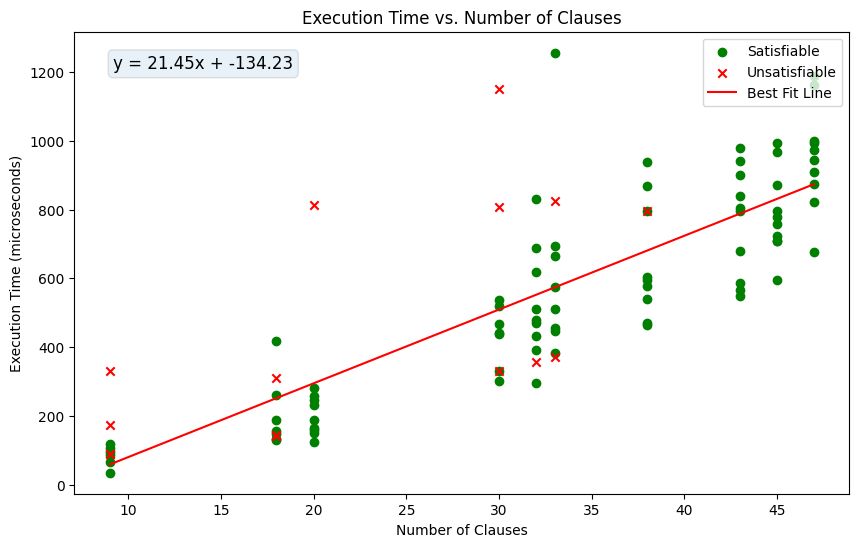

In [66]:
#code to plot the whole thing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('resultsfile.csv') #load data from csv

#setting graph point markers
sat_marker = 'o'
unsat_marker = 'x'

#make plot
plt.figure(figsize=(10, 6))

#plot satisfiable problems
plt.scatter(
    data[data['satisfiability'] == 'S']['num_clauses'],
    #data[data['satisfiability'] == 'S']['num_variables'],
    data[data['satisfiability'] == 'S']['exec_time'],
    label='Satisfiable',
    marker=sat_marker,
    color='green'
)

#plot unsatisfiable problems
plt.scatter(
    data[data['satisfiability'] == 'U']['num_clauses'],
    #data[data['satisfiability'] == 'U']['num_variables'],
    data[data['satisfiability'] == 'U']['exec_time'],
    label='Unsatisfiable',
    marker=unsat_marker,
    color='red'
)

# fit a linear regression model
#coefficients = np.polyfit(df['num_variables'], df['exec_time'], 1)  # 1 for linear
coefficients = np.polyfit(df['num_clauses'], df['exec_time'], 1)
slope, intercept = coefficients

# generate best fit line
#x_fit = np.linspace(df['num_variables'].min(), df['num_variables'].max(), 100)
x_fit = np.linspace(df['num_clauses'].min(), df['num_clauses'].max(), 100)
y_fit = slope * x_fit + intercept

plt.plot(x_fit, y_fit, color='red', label='Best Fit Line')

#add title and axis labels
#plt.xlabel('Number of Variables')
plt.xlabel('Number of Clauses')
plt.ylabel('Execution Time (microseconds)')
plt.title('Execution Time vs. Number of Clauses')

#add legend
plt.legend(loc='upper right')

#add equation for best fit line
equation_text = f"y = {slope:.2f}x + {intercept:.2f}"
plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1, edgecolor='black'))


#show plot
plt.show()